In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import kendalltau
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import the dataframes: 

In [2]:
'''Import data'''
#data_abs = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/phylum/abs_muskegon_phylum_5in10_otu_1in3.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/genus/rel_muskegon_genus_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_sampledata_5in10.tsv', sep= ' ', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)

In [3]:
index = target.Lake[target.Lake == 'Muskegon'].index

In [4]:
'''Set sample names as index and shuffle data'''

#Remove outlier samples:
#data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
#data_abs = data_abs.sample(frac=1, random_state=3)
#data_rel = data_rel.sample(frac=1, random_state=3)
#target = target.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[index,'HNA.cells']
hna_rel = hna/target.loc[index,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[index,'LNA.cells']
lna_rel = lna/target.loc[index,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [5]:
tot_bacprod = productivity.loc[:,'tot_bacprod'].dropna()
index_prod = tot_bacprod[tot_bacprod.values < 90].index
prod = productivity.loc[index_prod,'tot_bacprod']

In [6]:
fs_scores = pd.read_csv('Final/FS_Scores/Muskegon_fs_scores_HNA_5seq10_genus.csv', index_col=0)
fs_scores.sort_values('RL score', ascending=False, inplace=True)

''' Log-Ratio analyses '''
otus = list(data_rel.columns)
data_rel_repl = composition.multiplicative_replacement(data_rel.loc[:,otus])
data_rel_clr = pd.DataFrame(composition.clr(data_rel_repl), columns=otus, index=index)

In [7]:
kendall = np.zeros(len(otus))
p_kendall = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    kendall[i], p_kendall[i] = kendalltau(data_rel_clr.loc[index_prod,otus[i]],prod)
fs = pd.DataFrame(np.abs(kendall), index=otus, columns = ['kendall_prod'])
fs['p_kendall_prod'] = p_kendall
fs['kendall_significant_prod'] = np.where(fs.loc[otus,'p_kendall_prod']<0.05,'yes','no')

In [8]:
from statsmodels.sandbox.stats.multicomp import multipletests
fdr_bh = multipletests(p_kendall, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
fs['fdr_bh'] = fdr_bh[1]

In [21]:
fs_prod = pd.concat([fs_scores,fs], axis=1)
fs_prod.sort_values('p_kendall_prod', ascending=True, inplace=True)
display(fs_prod.iloc[:,4:])

,kendall significant,RL score,RL ranking,Boruta score,Boruta ranking,kendall_prod,p_kendall_prod,kendall_significant_prod,fdr_bh
Otu000730,yes,0.164,76.0,0.000862,84,0.547368,0.000740,yes,0.104332
Otu001166,no,0.102,131.0,0.000382,130,0.505263,0.001842,yes,0.104332
Otu001059,no,0.118,118.0,0.000318,167,0.494737,0.002290,yes,0.104332
Otu000041,no,0.156,84.0,0.074703,1,0.484211,0.002837,yes,0.104332
Otu000923,no,0.072,164.0,0.000145,186,0.463158,0.004302,yes,0.104332
Otu000614,yes,0.448,3.0,0.026856,4,0.463158,0.004302,yes,0.104332
Otu000075,yes,0.062,169.0,0.001528,51,0.463158,0.004302,yes,0.104332
Otu000116,no,0.114,124.0,0.000251,165,0.463158,0.004302,yes,0.104332
Otu000192,no,0.162,81.0,0.000342,113,0.421053,0.009444,yes,0.203574
Otu000006,no,0.062,169.0,0.001524,56,0.400000,0.013672,yes,0.236281


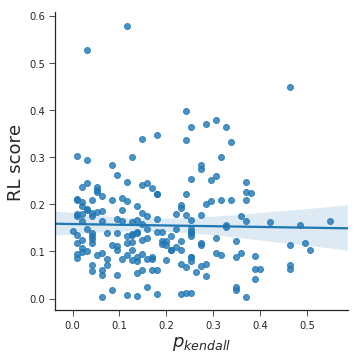

In [10]:
g = sns.lmplot(x='kendall_prod',y='RL score',data=fs_prod, fit_reg=True)
g.set_titles(size=22)
g.set_xlabels(r'$p_{kendall}$',fontsize=18)
g.set_ylabels(fontsize=18)
#g.fig.get_axes()[0].set_yscale('log')
plt.show()

In [11]:
fs.to_csv('Muskegon_fs_scores_HNA_5seq10_class_genus.csv')